## Program Design

### Folder Heirarchy

```
project
│   README.md
|   markdown-cheatsheet-online.pdf
│   HRTF_Estimation.ipynb    
|
│
└───Audio_devtest   #to test file iteration + processing not at-scale
│   │   file011.txt
|   │   file012.txt
│   └───MOS_test
│       │   file111.txt
│   
└───otherFolders
    │   file021.txt
```

### Logical Flow
1. Generate Database
    1. Generate Annotated Database (ambi_DB) of Ambisonic Representations of MongoDB Soundsources
    2. Obtain multiple HRTFs (HRTF_DB), annotated
    3. Create Secondary Annotated Database (main_DB) by convolving each in ambi_DB with each in HRTF_DB
2. Obtain MOS
    1. for each in main_DB
        1. Obtain 1 MOS for each in HRTF_DB
        2. Compare MOS values 
            a. search for hyperparameters that yield strong correlations
        3. Determine used HRTF for this from main_DB
3. Analysis + Discussion

In [ ]:
'''obtain_MOS notes / working thoughts:

--Before running the system, the input test signals are
assumed to be standardized/normalized to unitlength
and zero-mean, and the processed signal is
assumed to have been centered to zero-mean.
    ?? Is this still relevant? Need to test
    
--EN method requires HRIR, not SOFA



'''

## MOS Calculation

For one processed HRIR$(\alpha, \varphi)$ and test set of HRIRs indexed by $(\theta,\phi)$

Transform each into freq domain (fft)
log scale (magnitude dB)

Compare each processed HRIR$(\alpha, \varphi)$ to every in test set HRIR$(\theta,\phi)$ 
via both Elastic-Net Regression and Jensen-Shannon Distance

### Elastic-Net Regression (EN)

$\hat{\beta} = argmin_\beta||\textbf{y}- \textbf{X}\beta||^2 + \delta||\beta||^2 + \lambda||\beta||_1$

where: 
- **y** is the processed signal, 
- **X** is a matrix where each column is one HRIR from test set HRIR(θ,ϕ)
- $\beta$ is vector of coefficients produced by fitting the model
- "L2 norm" is defined as $||n||^2 = \sqrt{(|a|^2 + |b|^2)}$
    - where $n = (a, b)$ 
- δ is the L2 norm shrinkage parameter

- "L1 norm" is defined as $||n||_1 = |a| + |b|$
    - where $n = (a, b)$     
- λ is the L1 norm shrinkage parameter
    
and:
- $\hat{\beta}$ is the returned vector of coefficients, representing load on each predictor from test HRIR$(\theta,\phi)$ to reproduce the input response vector of HRIR$(\alpha, \varphi)$.

### Jenson-Shannon Distance (JSD)

Bounded and symmertical Kullback-Leibler (KL) divergence, measurement of similairty between two distributions. 

Computes the distance between the processed HRIR and all in test set. Lower values indivate statistically similar distributions, JSD of zero being identical. 

$JSD(P||T) = \sqrt{\frac{1}{2}[KL(P||\frac{P+T}{2}) + KL(T||\frac{P+T}{2})]}$

where: 
- $KL(P||T) = \sum(P(x)\frac{P(x)}{T(x)})$
- $P$ is the processed HRIR response
- $T$ is every member of Test HRIR set

### E-N distance computation

After computing EN distance between processed response signal HRIR$(\alpha, \varphi)$ and every member of the test set HRIR$(\theta,\phi)$, the returned $\hat{\beta}$ coefficients are indeced by \theta and \phi. 

Centroid + StdDev of $\hat{\beta}$ coefficients are of interest, as wel as angular distance from computed centroid to intended rendering position. Centroid must be calculated by first shifting distribution to center of image. 

**MOS-1** is the angular distance of computed centroid -> intended location

**MOS-2** is the std deviation of $\hat{\beta}$ coefficients as diffuse estimator

### JSD computation

JSD computed between processed HRIR$(\alpha, \varphi)$ and all in computed HRIR$(\theta,\phi)$, each value subtracted from 1 and plotted along azimuth + elevation axes. 

Angular Distance Map (ADM) is computed distance between intended location + every other location. ADM normalized between 0-1. 

**MOS-3** value at the index of ADM primary return index (highest coefficient value) of the JSD. Smaller MOS-3, more accurate rendering. 

**MOS-4** sum of all JSD coefficients multiplied by corresponding ADM values. Smaller MOS-4: more compact image. 

In [2]:
def read_in_HRTF(folderpath, filetype=".wav", verbose=False):

    '''
    Reads in an HRTF from file into a 72-by-15 array of stereo impulse responses
    
    HRTF Ele Positions(12): -75, -60, -45, -30, -15, 0, 15, 30, 45, 60, 75, 90
         Azi Positions(72): 0:355[::5]
    
    
    Parameters
    ----------
        folderpath (string) : 
        
        
        filetype (string) : which type of HRTF file this function will look for, 
            currently only working with .wav, but planning to extend to .sofa.
        
        "WAV" will search for .wav files, located in subfolder ##K_##bit
            filenaming convention is "azi_#,#_ele_#,#.wav"
            
            ##K is Sample Rate
            ##bit is bit depth
            Commas represent decimals, prepend (-) if negative.
            e.g. 15 deg azi, -17.3 deg ele = "azi_15,0_ele_-17,3.wav"
        
        "sofa" will search for .sofa files
            filenaming convention is "D#_##K_##bit_###tap_FIR_SOFA.sofa"
            
            D# is HRTF subject no. (SADIE II database)
            ##K is Sample Rate
            ##bit is bit depth
            ###tap is FIR length in samples
            e.g. "D2_48K_24bit_256tap_FIR_SOFA.sofa"

    Returns
    -------
    
        HRTF_out (np.ndarray, shape(72,1)) : 
    '''
    
    HRTF_out = np.ndarray((72, 12, 2, 256))
    
    if(verbose==True):
        print("HRTF Shape:", HRTF_out.shape)

    start_az = 0;
    start_el = -75;
    
    # azimuth and elevation increments of 5 and 15 degrees, respectively
    az_inc = 5;
    el_inc = 15;
    
    # number of azimuth and elevation measurements
    num_azi = 72;
    num_ele = 12;
    
    for az_idx in range(0, num_azi):
        for el_idx in range(0, num_ele):
            curr_az = start_az + int(az_idx * az_inc);
            curr_el = start_el + int(el_idx * el_inc);
            
            filename = folderpath + "azi_{:.1f}_ele_{:.1f}".format(curr_az, curr_el)\
                .replace('.',',') + ".wav";
            
            y, sr = librosa.load(filename, sr=None, mono=False);
            HRTF_out[az_idx, el_idx] = y;
    
    return HRTF_out, sr

In [1]:
## Imports

import numpy as np
import librosa
import scipy.signal
import IPython.display as ipd
import sys
import os
import soundfile as sf

from sklearn.linear_model import ElasticNet as EN
from sklearn.linear_model import ElasticNetCV
from sklearn.datasets import make_regression

import matplotlib.pyplot as plt
from scipy import ndimage

In [3]:
folderpath = "HRTFs/D1_HRIR_WAV/48K_24bit/";
kemar_HRTF, sr = read_in_HRTF(folderpath, ".wav")
print(kemar_HRTF.shape)

(72, 12, 2, 256)


In [4]:
def get_HRIR(HRTF, azi=0, ele=0, warnings=True, verbose=True):
    
    '''Get the closest corresponding impulse response to 
    
    
    Parameters
    ----------
        HRTF   : np.array, shape(72, 12, 2, 256)
            HRTF to pull IR from
            
        azi : integer
            azimuth angle, either 0 < azi < 360 or -180 < azi < 180
            
        ele : integer
            elevation angle,  -75 < ele < 90
            
        warnings : boolean
            allows for warnings printout
    
    Returns
    -------
        IR_out  :  np.array, shape(n, 2)
            Stereo Impulse response from chosen (or closest) azimuth and elevation
    '''
    # Flag to print out warning if input azi/ele didn't correspond with 
    closestChoiceFlag = False;
    negAziFlag = False;
    nearestAzi = 0;
    nearestEle = 0;
    
    # Check Azimuth input, convert to 0-359 if needed
    if (azi < 0 and azi >=-180):
        negAzi = azi;
        negAziFlag = True; # Adjusts warning for legibility
        azi = azi + 360;
    elif (azi <= -180 or azi >= 360):
        print("Error: Azimuth must be between 0 and 360 or -180 and 180. Your input:", azi);
        return -1;
    elif (azi == 360):
        azi = 0;
    
    # Check desired Azimuth value against known HRIR azimuth angles
    if (azi % 5 == 0):
        chosenAzi = azi
        aziIdx = int(chosenAzi / 5)
    else:
        closestChoiceFlag = True;
        chosenAzi = ((azi - azi % 5)) + (round(azi % 5 / 5) * 5)
        aziIdx = int(chosenAzi / 5)
        
        
    # Check Elevation input
    if (ele < -75 or ele > 90):
        print("Error: Elevation must be between -75 and 90. Your input:", ele);
        return -1;
    
    # Check desired Elevation value against known HRIR elevation angles
    if (ele % 15 == 0):
        chosenEle = ele
        eleIdx = int((chosenEle + 75) / 15);
    else:
        closestChoiceFlag = True;
        chosenEle = ((ele - ele % 15)) + (round(ele % 15 / 15) * 15)
        eleIdx = int((chosenEle + 75) / 15);
        
    if(verbose == True):
        print("Azi =", chosenAzi, "deg| Ele = ", chosenEle, "deg");
        print("AziIdx =",aziIdx,"| EleIdx =", eleIdx);
    
    # printout warning
    if (warnings == True and closestChoiceFlag == True):
        if (negAziFlag == True):
            print("Warning! Chosen Azi, Ele of [", negAzi, ele, "] do not match current HRTF set.",\
             "\nUsing nearest Azi, Ele fit of [", (chosenAzi - 360), chosenEle,\
             "]\n...To disable this warning, call function with 'warnings=False' ");
        else: 
            print("Warning! Chosen Azi, Ele of [", azi, ele, "] do not match current HRTF set.",\
             "\nUsing nearest Azi, Ele fit of [", chosenAzi, chosenEle,\
             "]\n...To disable this warning, call function with 'warnings=False' ");
            
    output = HRTF[aziIdx, eleIdx]
    
    return output

In [5]:
## read_in_HRTF Testing
folderpath = "HRTFs/D1_HRIR_WAV/48K_24bit/";
kemar_HRTF, sr = read_in_HRTF(folderpath, ".wav")

## get_HRIR Testing
convIR = get_HRIR(kemar_HRTF, -45, 45, warnings=True)
# ipd.Audio(convIR, rate=sr)

Azi = 315 deg| Ele =  45 deg
AziIdx = 63 | EleIdx = 8


In [6]:
## Rudimentary Convolution Testing - requires cell above to be run

## Load in sample to convolve
audiofile = "Bebop Drumset 08.wav";
y, sr2 = librosa.load(audiofile, sr=48000, mono=False, duration=1.5);  

# don't ask me why I had to swap channels to preserve L/R, I don't know
G = np.array([scipy.signal.fftconvolve(y[0], convIR[1]), scipy.signal.fftconvolve(y[1], convIR[0])])

# ipd.Audio(G, rate = sr)

In [7]:
def dB_weighted_fft(signal):
    '''
    Parameters
    ----------
    signal : np.ndarray [shape=(2,n)]

    Returns
    -------
    
    dB-weighted magnitude FFT of signal [shape=(2,(N_FFT / 2) - 1)]
    '''
    
    sig_L_fft = 20 * np.log10(np.abs(scipy.fft.fft(signal[0])))
    sig_R_fft = 20 * np.log10(np.abs(scipy.fft.fft(signal[1])))
    
    sig_L_fft = sig_L_fft[0:int(len(sig_L_fft)/2)]
    
    sig_R_fft = sig_R_fft[0:int(len(sig_R_fft)/2)]
    
    db_weighted_signal = np.array([sig_L_fft, sig_R_fft])
    return db_weighted_signal

## TODO: get batch convolution working so we can start with the MOS calculations


    
    



In [8]:
def new_IR_generation(audiofile, IR):
    '''
    Create a new IR through deconvolving audio signals after digital signal processing
    
    
    Parameters
    ----------
    audiofile : str
        processed audio signal to be deconvolced
    
    IR : str
        impulse response used to deconvolve signal
        

    Returns
    -------
    new_IR : np.array, shape (n,2) 
        new IR representing the digital signal processing 
    
    '''
   
    processed, fs = librosa.load(audiofile, sr=None, mono=False)
    original, fs = librosa.load(IR, sr=None, mono=False)
    
    #take FFT of both signals
    processedFFT = np.fft.fft(processed)
    originalFFT = np.fft.fft(original)
    
    #divide the two frequency complex vectors
    newFFT = processedFFT / originalFFT
    
    #bring back to time domain
    newIR = np.fft.ifft(newFFT)
    
    #cast to real numbers
    newIR = np.real(newIR)
    
    return new_IR

In [9]:
def prepare_data(convolved_signal, test_HRTF):
    '''
    Parameters
    ----------
    convolved_signal : np.ndarray [shape=(2,n)]
    
    test_HRTF : np.ndarrray [shape=(72, 12, 2, 256)]

    Returns
    -------
    
    db-scaled-fft 
    
    db-scaled-fft-of-HRTFs
    '''
    
    dB_signal = dB_weighted_fft(convolved_signal)
    
    dB_HRTF = np.empty((test_HRTF.shape[0],test_HRTF.shape[1],test_HRTF.shape[2],int(test_HRTF.shape[3]/2)));
    
    for n in range (0, test_HRTF.shape[0]):
        for m in range (0, test_HRTF.shape[1]):
            dB_HRTF[n,m] = dB_weighted_fft(test_HRTF[n,m])
        
    return dB_signal, dB_HRTF

In [10]:
## Testing prepare_data function

# G : convolved binaural signal from earlier cell

sig, test_HRTF = prepare_data(G, kemar_HRTF)

### Elastic-Net Regression (EN)

$\hat{\beta} = argmin_\beta||\textbf{y}- \textbf{X}\beta||^2 + \delta||\beta||^2 + \lambda||\beta||_1$

where: 
- **y** is the processed signal, 
- **X** is a matrix where each column is one HRIR from test set HRIR(θ,ϕ)
- $\beta$ is vector of coefficients produced by fitting the model
- "L2 norm" is defined as $||n||^2 = \sqrt{(|a|^2 + |b|^2)}$
    - where $n = (a, b)$ 
- δ is the L2 norm shrinkage parameter

- "L1 norm" is defined as $||n||_1 = |a| + |b|$
    - where $n = (a, b)$     
- λ is the L1 norm shrinkage parameter
    
and:
- $\hat{\beta}$ is the returned vector of coefficients, representing load on each predictor from test HRIR$(\theta,\phi)$ to reproduce the input response vector of HRIR$(\alpha, \varphi)$.

In [11]:
def flatten_HRTF(input_HRTF):
    '''
    flattens the first two dimensions of the HRTF, 
    typically indexed by [azi, ele] for the first two dimensions,
    in order to beter work with Elastic-Net Regression
    
    Parameters
    ----------
    input_HRTF : np.ndarray, [shape=(72, 12, 2, 256)
        

    Returns
    -------
    flattened_HRTF : np.ndarray, [shape=(1008, 2, 256)]
    
    '''
    idx = 0;
    flat_len = input_HRTF.shape[0] * input_HRTF.shape[1];
    
    flattened_HRTF = np.empty((flat_len, 2, 128));
    
    for i in range(0, input_HRTF.shape[0]):
        for j in range(0, input_HRTF.shape[1]):
            flattened_HRTF[idx] = input_HRTF[i, j];
            idx = idx + 1;
    
    return flattened_HRTF;

def flatten_HRTF_mono(input_HRTF):
    
    idx = 0;
    flat_len = input_HRTF.shape[0] * input_HRTF.shape[1]
    
    flattened_HRTF_L = np.empty((flat_len, 128));
    flattened_HRTF_R = np.empty((flat_len, 128));
    
    for i in range(0, input_HRTF.shape[0]):
        for j in range(0, input_HRTF.shape[1]):
            flattened_HRTF_L[idx] = input_HRTF[i, j, 0];
            flattened_HRTF_L[idx] = input_HRTF[i, j, 1];
            idx = idx + 1;
    
    return flattened_HRTF_L, flattened_HRTF_R;

In [12]:
## Testing flatten_HRTF
print(test_HRTF.shape)
flat_test = flatten_HRTF(test_HRTF)
flat_test.shape

(72, 12, 2, 128)


(864, 2, 128)

In [13]:
def process_elastic_net(azimuth, elevation, db_weighted_HRTF ):
    
    '''
    
    
    Parameters
    ----------
    
        

    Returns
    -------
    
    
    '''
# # Data should come in prepared
#     sig, test_HRTF = prepare_data(G, kemar_HRTF)

# Flatten input HRTF into a neat-o line for ease of EN, also split into mono
    flat_kemar = flatten_HRTF(db_weighted_HRTF)
    flat_kemar_L, flat_kemar_R = flatten_HRTF_mono(test_HRTF)

# Get db-weighted-HRIR at chosen azi/ele 
    db_HRIR = get_HRIR(db_weighted_HRTF, azimuth, elevation)
    proc_HRIR_L = db_HRIR[0]

# Train Regressor Model
    regr3 = ElasticNetCV(cv=5, random_state=0, max_iter=500, normalize=True)

    regr3.fit(flat_kemar_L.T,  proc_HRIR_L)

# Once Trained, Generate a score chart based on fitted model of original HRTF dims
# currently ignoring stereo

    beta_scores = np.empty((db_weighted_HRTF.shape[0], db_weighted_HRTF.shape[1]),\
                           dtype=float);
    
    scoring_idx = 0;
    for azi_idx in range(0, db_weighted_HRTF.shape[0]):
        for ele_idx in range(0, db_weighted_HRTF.shape[1]):
            proc_HRIR = get_HRIR(test_HRTF, (0 + (5 * azi_idx)), (-75 + (15 * ele_idx)),\
                                verbose=False)
            proc_HRIR_L = proc_HRIR[0]
            score = regr3.score(flat_kemar_L.T, proc_HRIR_L)
            beta_scores[azi_idx, ele_idx] = score;
    
    return beta_scores

In [14]:
## Testing process_Elastic_net using func

scores = process_elastic_net(0, 0, test_HRTF)
print(scores.shape)
print(scores[0])

Azi = 0 deg| Ele =  0 deg
AziIdx = 0 | EleIdx = 5


/Users/samplatt/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1695109790944187, tolerance: 0.1588605754253411
  model = cd_fast.enet_coordinate_descent(
/Users/samplatt/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1991297433556607, tolerance: 0.1588605754253411
  model = cd_fast.enet_coordinate_descent(
/Users/samplatt/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18838742806828002, tolerance: 0.1588605754253411
  model = cd_fast.enet_coordinate_descent(
/Users/samplatt/opt/anaconda3/lib/python3.8/site-packages

(72, 12)
[-1.35818942 -0.69327269 -0.59060273 -0.49850561  0.48933994  0.95232097
  0.65353976 -0.03680837 -1.05903541 -1.31903571 -2.00015348 -0.48572275]


In [15]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

print(scores[0])
scores_norm = NormalizeData(scores)
scores_e = scores_norm**np.e

centroid = ndimage.measurements.center_of_mass(scores_norm)
print(centroid)

stddev = np.std(scores)
print(stddev)

def rms(x):
    return np.sqrt(np.vdot(x,x)/x.size)

_rms = rms(scores)
print(_rms)

ndimage.measurements.histogram(scores, 0, 1, bins=15)

[-1.35818942 -0.69327269 -0.59060273 -0.49850561  0.48933994  0.95232097
  0.65353976 -0.03680837 -1.05903541 -1.31903571 -2.00015348 -0.48572275]
(32.350832767396156, 5.649257483307051)
1.6952527050835597
2.864214405530227


array([3, 3, 0, 0, 1, 4, 1, 2, 0, 1, 0, 2, 0, 0, 1])

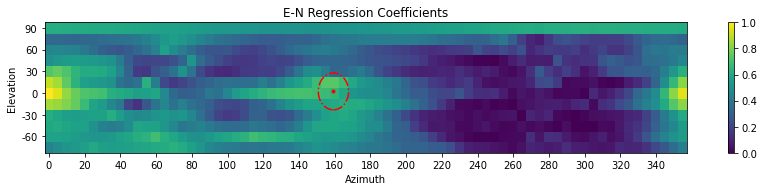

In [16]:
# plt.pcolor(scores.T)
# plt.colorbar()
# plt.axis('scaled')
# plt.figure(figsize=(40,10))

def center_scores(scores, azimuth_index):
    '''
    Params:
    
    Centers scores array so input HRTF(alpha, varphi) is centered in array
    
    -------
    scores : np.ndarray, shape=[n, m]
    
    azimuth : 
    
    Returns:
    --------
    shifted_scores : np.ndarray, [shape=(n, m)]
    
    xticklabels : np.ndarray, [shape=(n,)]
    '''
    
    # Need to create 3 sub-arrays: 
    # 'center' is [36]
    # EITHER: 
    #    if azi_idx == 0 
    #       azi = 0, slice 1 is 0:35, slice 2 is 36:71
    #       cat(slice2, slice 1)
    #    if 0 < azi_idx < 35
    #       slice 1 is azi_idx:azi_idx + 35, slice 2 is azi_idx + 35:71, slice 3 is 0:azi_idx
    #       cat(slice2, slice3, slice1)
    #    if azi_idx == 36
    #       it's centered, do nothing
    #    if 36 < axi_idx < 71
    #       slice 1 is azi_idx:71, slice 2 is 0:(azi_idx-36), slice 3 is azi_idx-35:azi_idx
    #       cat(slice3, slice 1, slice 2)
    
#     centered_scores = np.concat(scores[])
    
    return centered_scores, xticklabels

# plt_scores, xticklabels = shift_scores(scores_e)

fig = plt.figure(figsize=(14.4, 2.4))
ax = fig.add_subplot(111 )

ax.set_title("E-N Regression Coefficients")
ax.set_xlabel("Azimuth")
ax.set_xticks(np.arange(0.5,73.5, 4))
ax.set_xticklabels(np.arange(0, 361, 20))

ax.set_ylabel("Elevation")
ax.set_yticks(np.arange(1.5,13.5,2))
ax.set_yticklabels(np.arange(-60,91,30))

ax.pcolor(scores_e.T)

im=ax.pcolor(scores_e.T)
fig.colorbar(im, ax=ax)
plt.plot(centroid[0], centroid[1], '.r', label='centroid')
circle = plt.Circle((centroid[0], centroid[1]), stddev, color='red', fill=False, ls='-.', lw=1.5)
ax.add_artist(circle)

In [17]:
# # testing bones of elastic_net
sig, test_HRTF = prepare_data(G, kemar_HRTF)

flat_kemar = flatten_HRTF(test_HRTF)
flat_kemar_L, flat_kemar_R = flatten_HRTF_mono(test_HRTF)

proc_HRIR = get_HRIR(kemar_HRTF, 0, 0)
db_HRIR = dB_weighted_fft(proc_HRIR)
proc_HRIR_L = db_HRIR[0]
proc_HRIR_R = db_HRIR[1]

# plt.plot(test_HRTF[0,5,0])
# plt.plot(proc_HRIR_L)

regr3 = ElasticNetCV(cv=5, random_state=0, normalize=False)
print(flat_kemar_L.T.shape, proc_HRIR_L.shape)

regr3.fit(flat_kemar_L.T,  proc_HRIR_L)

Azi = 0 deg| Ele =  0 deg
AziIdx = 0 | EleIdx = 5
(128, 864) (128,)


ElasticNetCV(cv=5, random_state=0)

In [18]:
proc_HRIR = get_HRIR(test_HRTF, 0, 0)
proc_HRIR_L = proc_HRIR[0]

score = regr3.score(flat_kemar_L.T, proc_HRIR_L)
print(score)

Azi = 0 deg| Ele =  0 deg
AziIdx = 0 | EleIdx = 5
0.9875294942970827


In [19]:
## Indexing stuff

# print(np.argmax(regr2.coef_))
HRTF_phi_idx = np.argmax(regr2.coef_) % kemar_HRTF.shape[0]
HRTF_theta_idx = int(np.floor(np.argmax(regr2.coef_) / kemar_HRTF.shape[0]))
HRTF_phi_idx
HRTF_theta_idx
# print(kemar_HRTF[0:10,:,0,0:5])

NameError: name 'regr2' is not defined

In [ ]:
def obtain_MOS (audiofile_path, HRTF_path):
    
    '''Get MOS (np.array) from Audiofile for Specific HRTF
    
    MOS = {MOS-1, MOS-2, MOS-3, MOS-4}
    
    Parameters
    ----------
    audiofile_path : str
        file name (*.wav) incl. path of stereo binaural signal
        
    HRTF_path: str
        HRTF folder including (*.wav) HRIRs for convolution
        
        

    Returns
    -------
    MOS : np.array, shape = (1, 4)
        outputs 4 MOS values for input audio file:
        
        MOS-1: (E-N) Localization Precision of Spectral Magnitude
        MOS-2: (E_N) Sptatial Variation / "Spread" of Spectral Magnitude
        MOS-3: (JSD) Localization Precision of Spectral Magnitude
        MOS-4: (JSD) Sptatial Variation / "Spread" of Spectral Magnitude
        

    
    
    
    '''


    
    pass


In [ ]:
iteration1 = new_IR_generation('Binaural_Chorus_Files/Iteration1_48k_24bit.wav', 'Binaural_Chorus_Files/dry_vox_48k_24bit.wav')
iteration2 = new_IR_generation('Binaural_Chorus_Files/Iteration2_48k_24bit.wav', 'Binaural_Chorus_Files/dry_vox_48k_24bit.wav')
iteration3 = new_IR_generation('Binaural_Chorus_Files/Iteration3_48k_24bit.wav', 'Binaural_Chorus_Files/dry_vox_48k_24bit.wav')
iteration4 = new_IR_generation('Binaural_Chorus_Files/Iteration4_48k_24bit.wav', 'Binaural_Chorus_Files/dry_vox_48k_24bit.wav')
iteration5 = new_IR_generation('Binaural_Chorus_Files/Iteration5_48k_24bit.wav', 'Binaural_Chorus_Files/dry_vox_48k_24bit.wav')
iteration6 = new_IR_generation('Binaural_Chorus_Files/Iteration6_48k_24bit.wav', 'Binaural_Chorus_Files/dry_vox_48k_24bit.wav')
iteration7 = new_IR_generation('Binaural_Chorus_Files/Iteration7_48k_24bit.wav', 'Binaural_Chorus_Files/dry_vox_48k_24bit.wav')

In [ ]:
ipd.Audio(iteration7, rate=48000)